# Task 1 : Set up colab gpu runtime environment

In [57]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-a635b4fl
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-a635b4fl
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [58]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


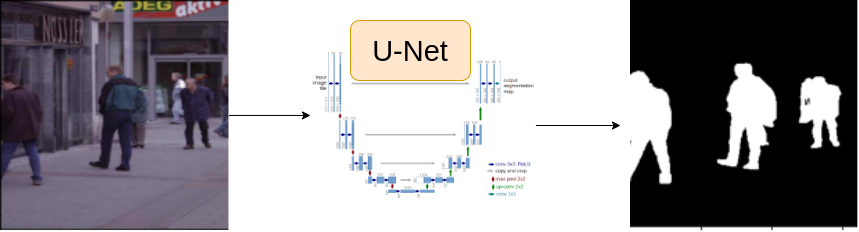

# Some Common Imports

In [59]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [60]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [99]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE  = 'cuda'
EPOCHS= 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [62]:
df = pd.read_csv(CSV_FILE)
df.head()

masks  \
0  Human-Segmentation-Dataset-master/Ground_Truth...   
1  Human-Segmentation-Dataset-master/Ground_Truth...   
2  Human-Segmentation-Dataset-master/Ground_Truth...   
3  Human-Segmentation-Dataset-master/Ground_Truth...   
4  Human-Segmentation-Dataset-master/Ground_Truth...   

                                              images  
0  Human-Segmentation-Dataset-master/Training_Ima...  
1  Human-Segmentation-Dataset-master/Training_Ima...  
2  Human-Segmentation-Dataset-master/Training_Ima...  
3  Human-Segmentation-Dataset-master/Training_Ima...  
4  Human-Segmentation-Dataset-master/Training_Ima...

In [63]:
row = df.iloc[0]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

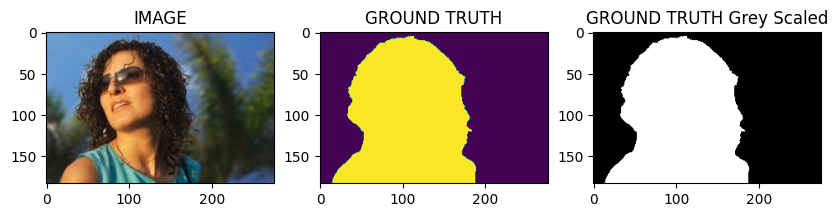

In [64]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask)

ax3.set_title('GROUND TRUTH Grey Scaled')
ax3.imshow(mask,cmap = 'gray')

In [65]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [66]:
import albumentations as alb

In [78]:
def get_train_augs():
  return alb.Compose([
      alb.Resize(IMAGE_SIZE, IMAGE_SIZE),
      alb.HorizontalFlip(p = 0.5),
      alb.VerticalFlip(p = 0.5)
  ], is_check_shapes=False)

def get_valid_augs():
  return alb.Compose([
      alb.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [79]:
from torch.utils.data import Dataset

In [80]:
class Segmentation_Dataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w)
    mask = np.expand_dims(mask, axis = -1) # (h, w, c)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    # (h, w, c) -> # (c, h, w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask



In [81]:
trainset = Segmentation_Dataset(train_df, get_train_augs())
validset = Segmentation_Dataset(valid_df, get_valid_augs())

In [82]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


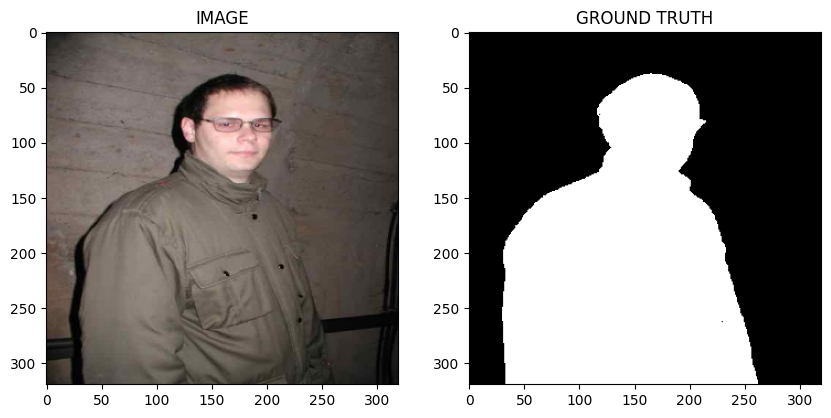

In [90]:
idx = 210

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [84]:
from torch.utils.data import DataLoader

In [85]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = True)

In [86]:
print(f'Total # batches in trainloader :{len(trainloader)}')
print(f'Total # batches in validloader :{len(validloader)}')

Total # batches in trainloader :15
Total # batches in validloader :4


In [87]:
for image, mask in trainloader :
  break
print(f'One batch image batch: {image.shape}')
print(f'One batch mask batch: {mask.shape}')

One batch image batch: torch.Size([16, 3, 320, 320])
One batch mask batch: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [92]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [100]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels= 3,
        classes = 1,
        activation= None
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1= DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2

    return logits

In [101]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 154MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

# Task 8 : Train Model

# Task 9 : Inference